# GRU 
(Gated Recurreny Units)

These were a simple and less heavy alternative of LSTMs, it has only 2 gates - Update gate and Reset Gate.

![WhatsApp Image 2025-07-10 at 15.58.54_cac2dd14.jpg](<attachment:WhatsApp Image 2025-07-10 at 15.58.54_cac2dd14.jpg>)
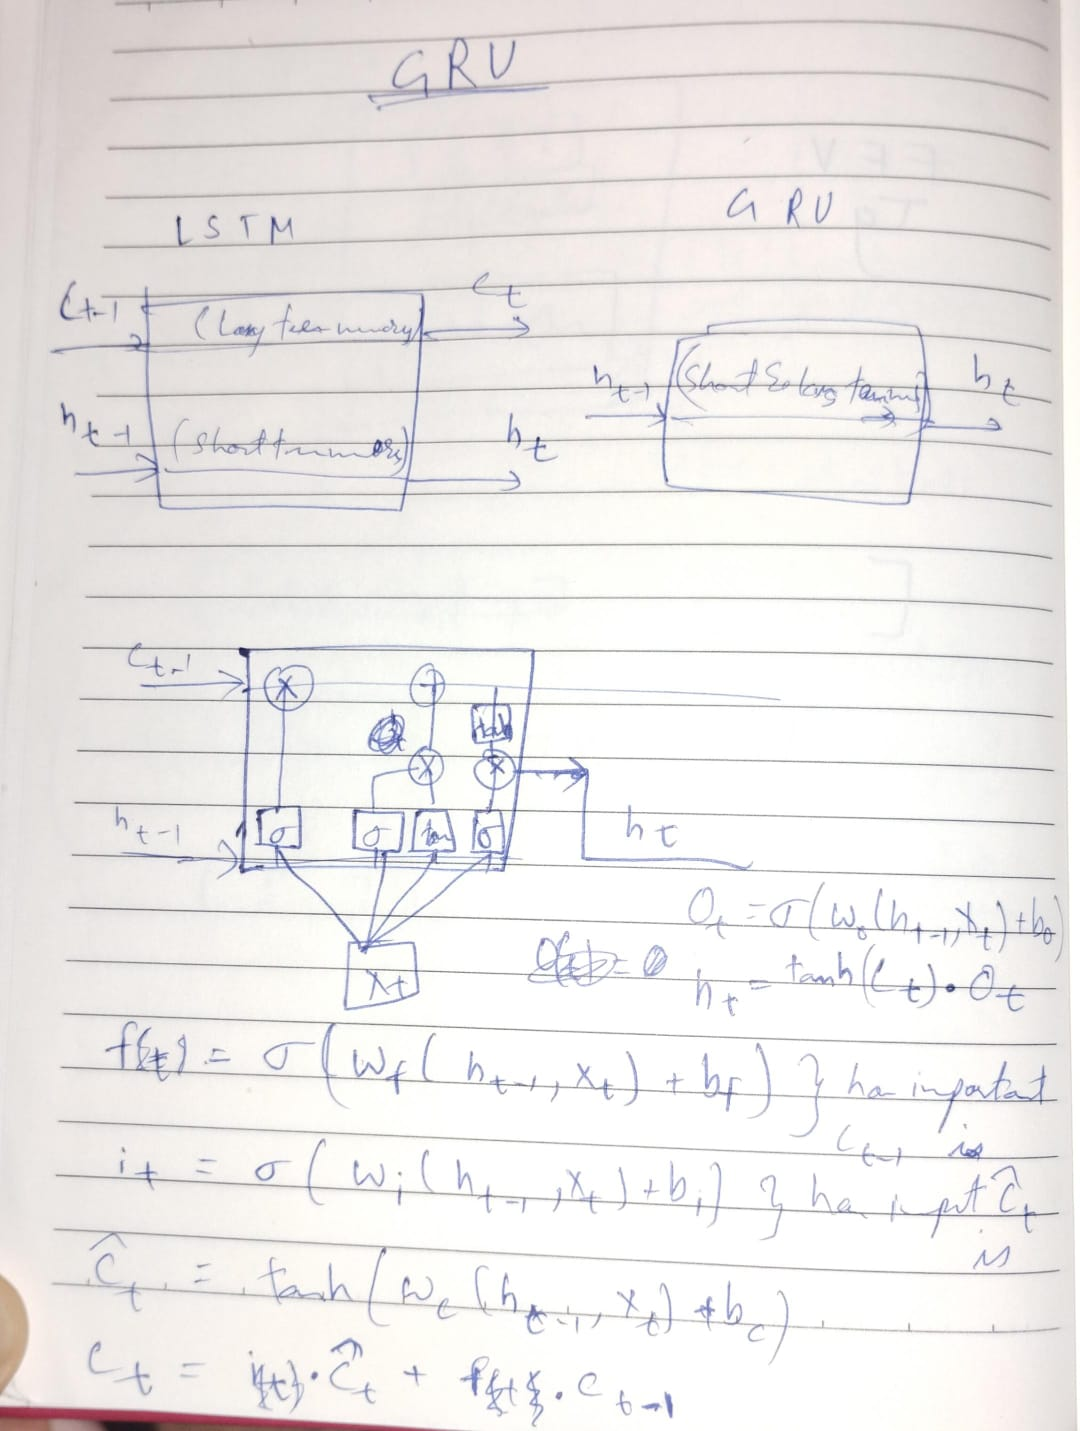

![WhatsApp Image 2025-07-10 at 15.59.16_d621923b.jpg](<attachment:WhatsApp Image 2025-07-10 at 15.59.16_d621923b.jpg>)
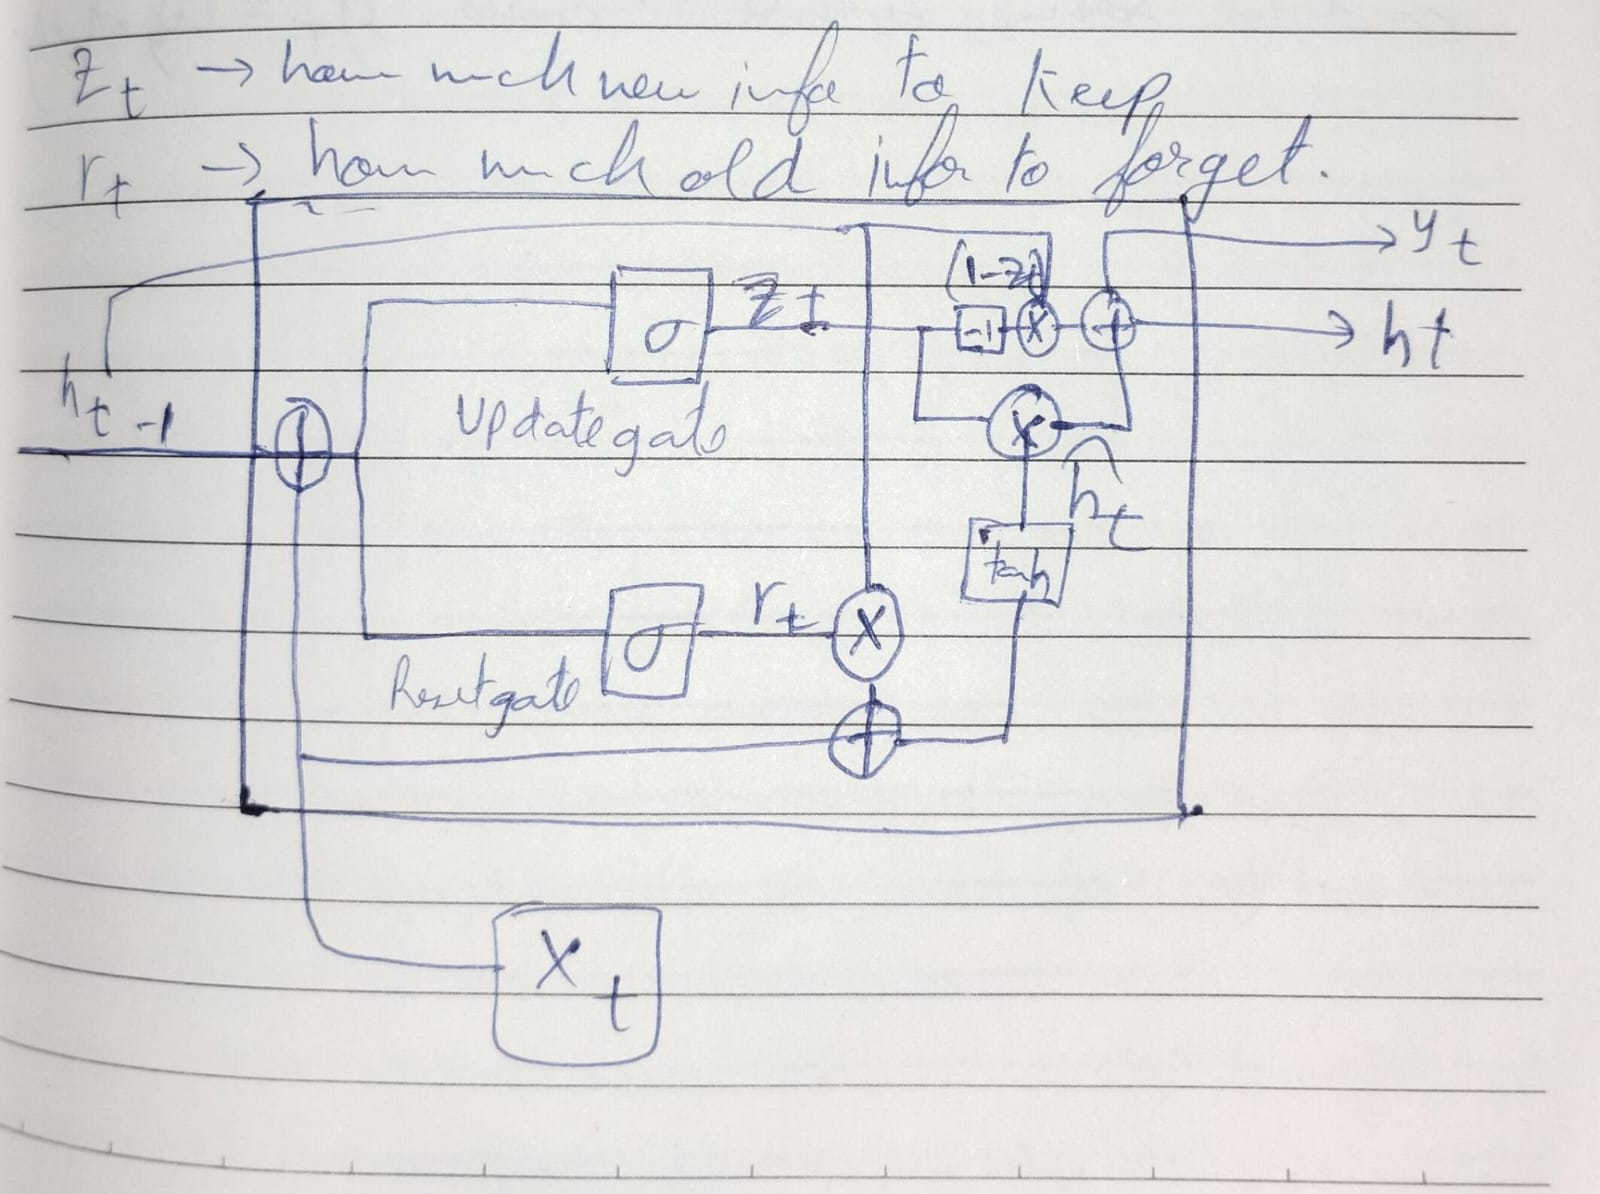

![WhatsApp Image 2025-07-10 at 15.59.40_da30e9c8.jpg](<attachment:WhatsApp Image 2025-07-10 at 15.59.40_da30e9c8.jpg>)
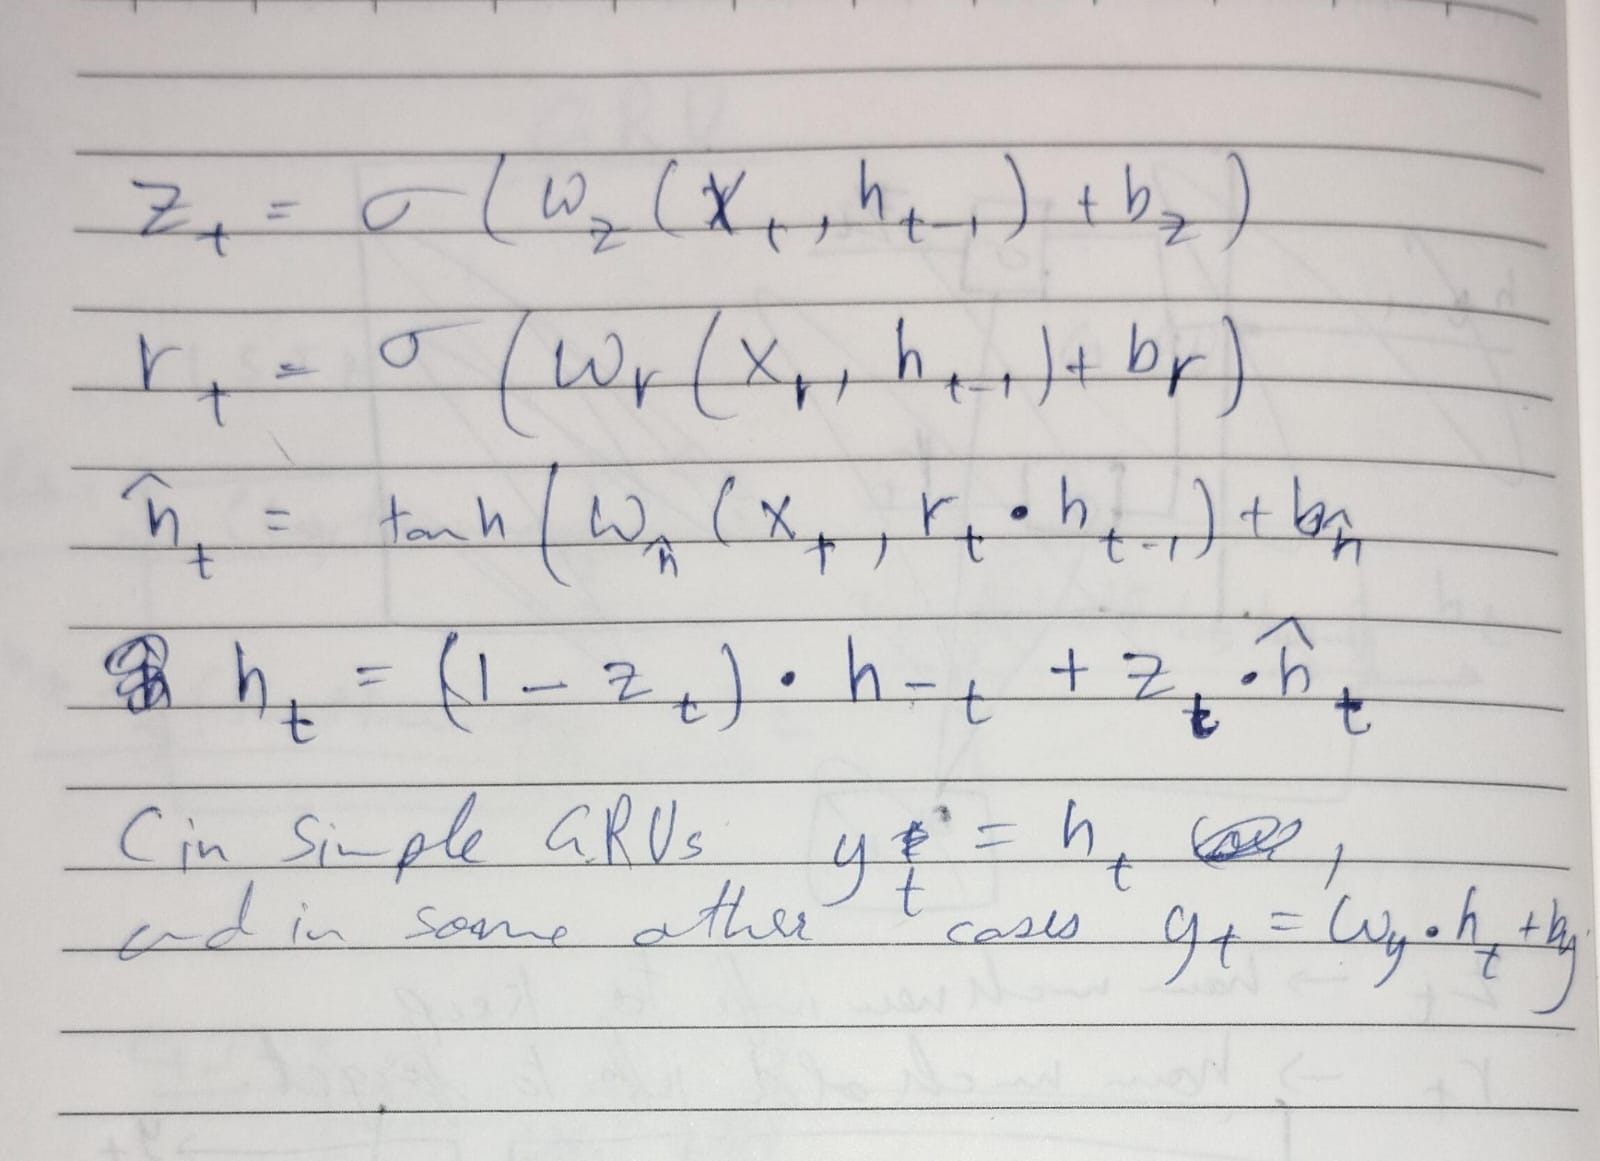

## Why this didnt Work?

Raw audio data is highly sensitive (to produce 1 second worth of data, 22050 or maybe more values need to be predicted) so initially if data is noisy then the error accumulates and the predictions goes off very quickly.

In [2]:
import numpy as np
import pandas as pd
import os
import librosa
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio, display

In [3]:
dir= "/kaggle/input/ravdess-emotional-speech-audio"
actor_list= os.listdir(dir)
data_dir= os.path.join(dir, actor_list[0])

audio_list= os.listdir(data_dir)

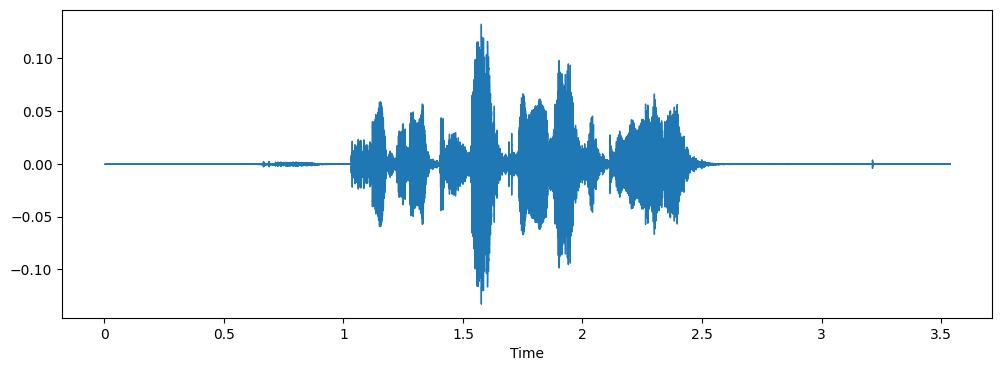

In [52]:
file= os.path.join(data_dir, audio_list[0])

signal, sr= librosa.load(file)

display(Audio(data= signal, rate=sr))

plt.figure(figsize=(12, 4))
librosa.display.waveshow(signal, sr=sr)

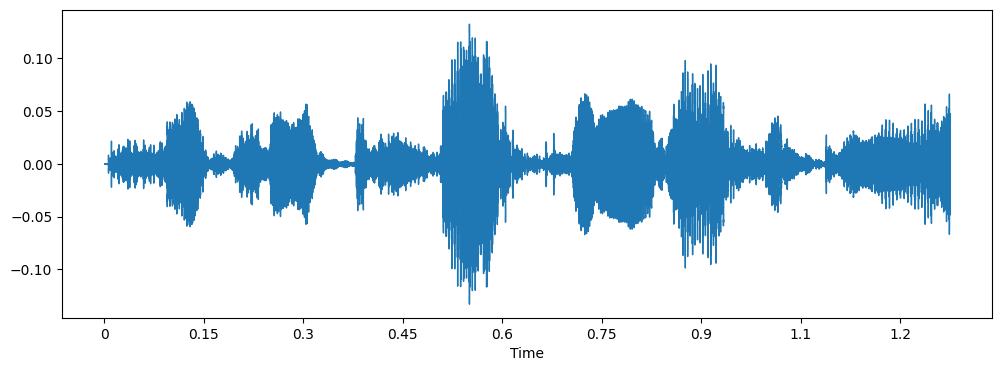

In [53]:
file= os.path.join(data_dir, audio_list[0])

signal, sr= librosa.load(file)

display(Audio(data= signal[int(sr*1.025):int(sr*2.3)], rate=sr))

plt.figure(figsize=(12, 4))
librosa.display.waveshow(signal[int(sr*1.025):int(sr*2.3)], sr=sr)

In [54]:
print(int(sr*0.050)) 

1102


In [55]:
print(np.max(signal), np.min(signal))
data= signal[int(sr*1.025):int(sr*2.3)].tolist()
print(len(data))

0.13247547 -0.1162357
28113


In [ ]:
# def null_check(temp):
#     flag= 1
#     for i in range(len(temp)):
#         if temp[i] != float(0):
#             flag=0
#     return flag

# def process(data, check_windown):
#     check_windown= check_windown
#     start= 0
#     end= len(data)-1
#     temp1=[]
#     temp2=[]
#     for i in range(len(data)):
#         temp1= data[x: x + check_window]
#         if null_check(temp1):
#             x= x+check_window

**Create Time Series data**

In [71]:
def create_data(data, time_step):
    X= []
    y= []
    for i in range(len(data) - time_step - 1):
        y.append(data[i + time_step])
        X.append(data[i: i + time_step])

    return np.array(X), np.array(y)

time_step= 1000

X, y= create_data(data, time_step)
X= X.reshape(X.shape[0], X.shape[1], 1)

print(X.shape)
print(y.shape)

(27112, 1000, 1)
(27112,)


In [72]:
from sklearn.model_selection import train_test_split as tts

X_train, X_test, y_train, y_test= tts(X, y, test_size=0.25, random_state=42) 

print(X_train.shape)
print(y_train.shape)

(20334, 1000, 1)
(20334,)


In [73]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

model= models.Sequential([
    layers.Input(shape=(X.shape[1], 1)),
    layers.GRU(units= 128, return_sequences=True),
    layers.GRU(units= 64),
    layers.Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mean_absolute_error'])

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_10 (GRU)                         │ (None, 1000, 128)           │          50,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_11 (GRU)                         │ (None, 64)                  │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 87,617 (342.25 KB)

 Trainable params: 87,617 (342.25 KB)

 Non-trainable params: 0 (0.00 B)

In [74]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

early_stop = EarlyStopping(
    monitor='val_loss',    
    patience=4,            
    restore_best_weights=True  
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',   
    factor=0.5,            
    patience=2,            
    min_lr=1e-6,           
    verbose=1
)

In [75]:
history= model.fit(X_train, y_train, epochs= 20, batch_size= 32, validation_split=0.25, callbacks=[early_stop, reduce_lr])

Epoch 1/20
477/477 ━━━━━━━━━━━━━━━━━━━━ 32s 62ms/step - loss: 1.4774e-04 - mean_absolute_error: 0.0076 - val_loss: 4.6285e-05 - val_mean_absolute_error: 0.0046 - learning_rate: 0.0010
Epoch 2/20
477/477 ━━━━━━━━━━━━━━━━━━━━ 29s 62ms/step - loss: 4.2778e-05 - mean_absolute_error: 0.0042 - val_loss: 4.2304e-05 - val_mean_absolute_error: 0.0041 - learning_rate: 0.0010
Epoch 3/20
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 4.3908e-05 - mean_absolute_error: 0.0041
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
477/477 ━━━━━━━━━━━━━━━━━━━━ 30s 62ms/step - loss: 4.3904e-05 - mean_absolute_error: 0.0041 - val_loss: 4.4272e-05 - val_mean_absolute_error: 0.0044 - learning_rate: 0.0010
Epoch 4/20
477/477 ━━━━━━━━━━━━━━━━━━━━ 30s 62ms/step - loss: 4.1010e-05 - mean_absolute_error: 0.0039 - val_loss: 4.1256e-05 - val_mean_absolute_error: 0.0040 - learning_rate: 5.0000e-04
Epoch 5/20
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 4.1006e-05 - mean_absolute_error

In [76]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred= model.predict(X_test)

mae= mean_absolute_error(y_test, y_pred)
mse= mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2= r2_score(y_test, y_pred)

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2:", r2)

212/212 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step
MAE: 0.0035976388201630254
MSE: 3.9915807370778475e-05
RMSE: 0.006317895802462912
R2: 0.8910223456760984


In [77]:
test_data = data.copy() 

num_pred = 1000
count = 0

while count < num_pred:
    test = test_data[-time_step:]  
    test = np.array(test).reshape(1, time_step, 1)  

    next_pred = model.predict(test, verbose=0)  
    test_data.append(float(next_pred[0][0]))  

    count += 1

print(len(data))
print(len(test_data))  


28113
29113


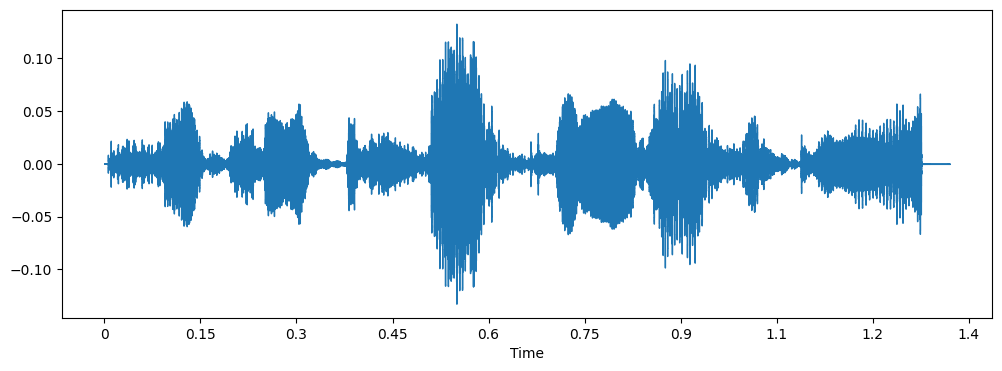

In [79]:
test_data= np.array(test_data)

display(Audio(data= test_data, rate= sr))

plt.figure(figsize=(12,4))
librosa.display.waveshow(test_data, sr=sr)